In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
from hmmlearn import hmm
import seaborn as sns  
import tensorflow as tf 
from keras.layers import Input, Dense, BatchNormalization
from tensorflow import keras
from tensorflow.keras import Input, Model
from tensorflow.keras.layers import Layer,Dropout
from keras.layers.advanced_activations import LeakyReLU  
from keras.layers.merge import concatenate  
from keras.models import Sequential, Model  
from tensorflow.keras.optimizers import Adam  
from tensorflow.keras.utils import to_categorical  
from sklearn.preprocessing import MinMaxScaler, LabelEncoder  
from sklearn import preprocessing
%matplotlib inline

# Data Collection

In [2]:
Bot_Data = pd.read_csv('b_users.csv',delimiter=',')
Bot_Data1 = pd.read_csv('b_users1.csv',delimiter=',')
Bot_Data2 = pd.read_csv('b_users2.csv',delimiter=',')
Bot_Data3 = pd.read_csv('b_users3.csv',delimiter=',')
Bot_Data4 = pd.read_csv('b_users4.csv',delimiter=',')
Bot_Data5 = pd.read_csv('b_users5.csv',delimiter=',')
Bot_Data6 = pd.read_csv('b_users6.csv',delimiter=',')
Bot_Data = Bot_Data.append([Bot_Data1,Bot_Data2,Bot_Data3,Bot_Data4,Bot_Data5,Bot_Data6],ignore_index=True)
print (Bot_Data)

             id                  name      screen_name  statuses_count  \
0      24858289        Davide Bertoli        davideb66            1299   
1      33212890        Elisa D'Ospina     ElisaDospina           18665   
2      39773427       Donato Vincenzo       Vladimir65           22987   
3      57007623    Rafiela Morales L.   RafielaMorales            7975   
4      63258466          § h a † u r♄      FabrizioC_c           20218   
...         ...                   ...              ...             ...   
7538  818079408  Columbia Facil. Mgmt  tmj_cae_facmgmt              41   
7539  846108068      NJ Business/Mgmt      tmj_nj_mgmt             218   
7540  857076271      PR Customer Ser.   tmj_ptr_cstsrv              17   
7541  872126906      PR Soft Dev Java   tmj_ptr_itjava               2   
7542  979406250  Harrisburg Cust. Ser   tmj_hpa_cstsrv              47   

      followers_count  friends_count  favourites_count  listed_count  \
0                  22             40   

In [8]:
Human_Data = pd.read_csv('g_users.csv',delimiter=',')
print (Human_Data)

              id               name      screen_name  statuses_count  \
0     1502026416    TASUKU HAYAKAWA         0918Bask            2177   
1     2492782375              ro_or         1120Roll            2660   
2      293212315           bearclaw        14KBBrown            1254   
3      191839658  pocahontas farida      wadespeters          202968   
4     3020965143           Ms Kathy  191a5bd05da04dc              82   
...          ...                ...              ...             ...   
3469   205218909         Alejandro   zombiemaster999             315   
3470  2874966164    Zubair Niazi Ⓜ️   zubairniaziPTI            4099   
3471  2980901837            Zuhazuu         zuhazuu1             199   
3472   121122678            zveljka          zveljka            2609   
3473  2910276853       // karime //      cypherjimin           20997   

      followers_count  friends_count  favourites_count  listed_count  \
0                 208            332               265         

In [9]:
data=Bot_Data.append(Human_Data,ignore_index=True)
data=data[['statuses_count','followers_count','friends_count','favourites_count','listed_count','Label']]
data

,statuses_count,followers_count,friends_count,favourites_count,listed_count,Label
0,1299,22,40,1,0,1
1,18665,12561,3442,16358,110,1
2,22987,600,755,14,6,1
3,7975,398,350,11,2,1
4,20218,413,405,162,8,1
...,...,...,...,...,...,...
11012,315,94,597,36,4,0
11013,4099,5378,1238,471,6,0
11014,199,18,136,6,0,0
11015,2609,41,263,121,0,0


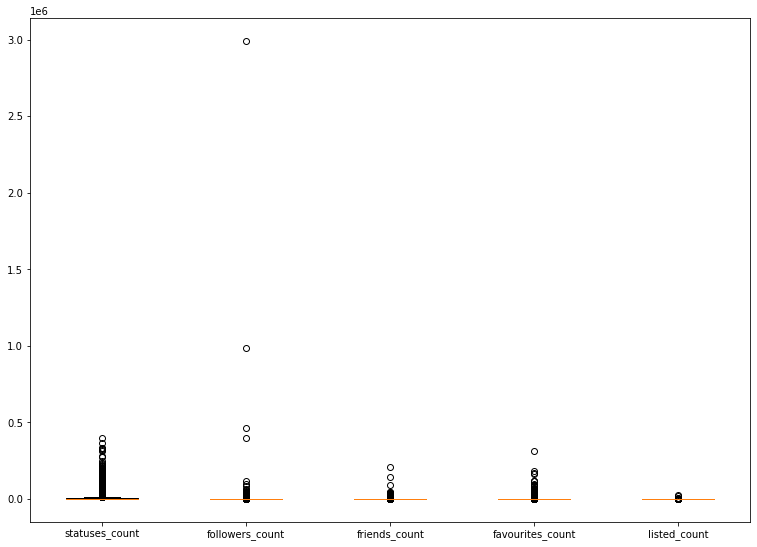

In [10]:
fig = plt.figure(figsize =(10, 7))
 
# Creating axes instance

ax = fig.add_axes([0, 0, 1, 1])
# Creating plot
bp = ax.boxplot(data.loc[:,data.columns!='Label'])
plt.xticks([1,2,3,4,5],['statuses_count','followers_count','friends_count','favourites_count','listed_count'])
# show plot
plt.show()

In [11]:
Q1 = data.quantile(0.25)
Q3 = data.quantile(0.75)
IQR = Q3 - Q1
((data < (Q1 - 1.5 * IQR)) | (data > (Q3 + 1.5 * IQR))).sum()

statuses_count      1845
followers_count     1037
friends_count       1449
favourites_count    2346
listed_count        1508
Label               2474
dtype: int64

# Data Scaling

In [12]:
df_minority_data=data.loc[data['Label'] == 0]  

#Subsetting input features without target variable
df_minority_data_withouttv=df_minority_data.loc[:, df_minority_data.columns != 'Label']
numerical_df = df_minority_data_withouttv.select_dtypes("number")  
scaling = MinMaxScaler()  
numerical_df_rescaled = scaling.fit_transform(numerical_df)    
numerical_df_rescaled

array([[5.92067279e-03, 2.09761298e-04, 7.16907795e-03, 1.57727768e-03,
        1.62179695e-04],
       [7.23607525e-03, 3.33388729e-04, 1.04729000e-02, 2.36413092e-02,
        8.10898476e-04],
       [3.40697408e-03, 1.67201034e-04, 3.82206867e-03, 7.05310962e-03,
        0.00000000e+00],
       ...,
       [1.11550486e-02, 5.44872704e-03, 2.67328871e-02, 2.80338787e-03,
        9.73078171e-04],
       [5.33786507e-04, 1.72267732e-05, 2.93673073e-03, 3.57119474e-05,
        0.00000000e+00],
       [7.09718183e-03, 4.05335841e-05, 5.67911898e-03, 7.20190940e-04,
        0.00000000e+00]])

# Data Balancing (GAN model Building)

## Generator Building

In [24]:
def define_generator (numerical):    
  #Inputting noise  from latent space
    noise = Input(shape = (1,70))  
    hidden_1 = Dense(8)(noise)    
    hidden_1 = LeakyReLU(0.2)(hidden_1)    
    hidden_1 = BatchNormalization(momentum = 0.8)(hidden_1)    
    hidden_2 = Dense(16)(hidden_1)    
    hidden_2 = LeakyReLU(0.2)(hidden_2)    
    hidden_2 = BatchNormalization(momentum = 0.8)(hidden_2)    
    branch_1 = Dense(64)(hidden_2)    
    branch_1 = LeakyReLU(0.2)(branch_1)    
    branch_1 = BatchNormalization(momentum = 0.8)(branch_1)    
    branch_1 = Dense(128)(branch_1)    
    branch_1 = LeakyReLU(0.2)(branch_1)    
    branch_1 = BatchNormalization(momentum = 0.8)(branch_1)    
    
    branch_1_output = Dense(numerical, activation = "sigmoid")(branch_1)    

    combined_output = concatenate([branch_1_output])    

    #Return model 

    return Model(inputs = noise, outputs = combined_output)    

    
generator = define_generator(numerical_df_rescaled.shape[1]) 
generator.summary()

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_10 (InputLayer)       [(None, 1, 70)]           0         
                                                                 
 dense_16 (Dense)            (None, 1, 8)              568       
                                                                 
 leaky_re_lu_8 (LeakyReLU)   (None, 1, 8)              0         
                                                                 
 batch_normalization_8 (Batc  (None, 1, 8)             32        
 hNormalization)                                                 
                                                                 
 dense_17 (Dense)            (None, 1, 16)             144       
                                                                 
 leaky_re_lu_9 (LeakyReLU)   (None, 1, 16)             0         
                                                           

## Discriminator (GRU based) Building 

In [25]:
from tensorflow.keras.layers import GRU
from keras.layers import TimeDistributed
from keras.layers import Activation

def define_discriminator(inputs_n):  
    spec_start = Input((1,inputs_n))
    spec_x = spec_start
    for _r in [32,32]:
        spec_x = GRU(_r, activation='tanh', dropout=0.5, recurrent_dropout=0.5, return_sequences=True)(spec_x)
    for _f in [32]:
        spec_x = TimeDistributed(Dense(_f))(spec_x)
        spec_x = Dropout(0.5)(spec_x)
        spec_x = TimeDistributed(Dense(10))(spec_x)
        out = Activation('sigmoid', name='strong_out')(spec_x)
    _model = Model(inputs=spec_start, outputs=out)
    _model.compile(optimizer='Adam', loss='binary_crossentropy',metrics = ['accuracy'])
    return _model


inputs_n = numerical_df_rescaled.shape[1]
discriminator = define_discriminator(inputs_n)  
discriminator.summary()

Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_11 (InputLayer)       [(None, 1, 5)]            0         
                                                                 
 gru_10 (GRU)                (None, 1, 32)             3744      
                                                                 
 gru_11 (GRU)                (None, 1, 32)             6336      
                                                                 
 time_distributed_6 (TimeDis  (None, 1, 32)            1056      
 tributed)                                                       
                                                                 
 dropout_3 (Dropout)         (None, 1, 32)             0         
                                                                 
 time_distributed_7 (TimeDis  (None, 1, 10)            330       
 tributed)                                                 

In [26]:
from keras.utils.np_utils import to_categorical

def define_complete_gan(generator, discriminator):  
    discriminator.trainable = False  
    gan_output = discriminator(generator.output)  
    
    #Initialize gan
    model = Model(inputs = generator.input, outputs = gan_output)  

    #Model Compilation
    model.compile(loss = "binary_crossentropy", optimizer = Adam(lr=0.0002, beta_1=0.5))  
    return model  

completegan = define_complete_gan(generator, discriminator)  

def gan_train(gan, generator, discriminator,numerical, latent_dim, n_epochs, n_batch, n_eval):  
    #Upddte Discriminator with half batch size
    half_batch = int(n_batch / 2)  
    discriminator_loss = []  
    generator_loss = []  
    #generate class labels for fake and real
    valid = np.ones((half_batch, 1))
    y_gan = np.ones((n_batch, 1))  
    fake = np.zeros((half_batch, 1))  

    #training
    for i in range(n_epochs):  
        #select random batch from real categorical and numerical data
        idx = np.random.randint(0, numerical_df_rescaled.shape[0], half_batch)                 
        numerical_real = numerical_df_rescaled[idx]  

        #concatenate categorical and numerical data for the discriminator
        real_data = np.concatenate([numerical_real],axis=1)  
  
        #generate fake samples from the noise
        noise = np.random.normal(0, 1, (half_batch,1, latent_dim)) 
        fake_data = generator.predict(noise)  
        #train the discriminator and return losses and acc


latent_dim = 70
gan_train(completegan, generator, discriminator,numerical_df_rescaled, latent_dim, n_epochs = 2000, n_batch = 2, n_eval = 200)

C:\Users\GAYATHRI\anaconda3\lib\site-packages\keras\optimizer_v2\adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [67]:
noise = np.random.normal(0, 1, (4500,1, 70))  
generated_mixed_data = generator.predict(noise)  
columns=list(numerical_df.columns)
mixed_gen_df = pd.DataFrame(data = generated_mixed_data.reshape(4500,5), columns = columns) 

In [68]:
generated_mixed_data.reshape

<function ndarray.reshape>

In [69]:
df_generated_data = pd.DataFrame()   
df_generated_data = mixed_gen_df.copy()
df_generated_data['Label']=0

# Data Prepocessing

In [70]:
from sklearn import preprocessing

#Encoding Data
encoder_statuses_count = preprocessing.LabelEncoder()  
encoder_followers_count = preprocessing.LabelEncoder()  
encoder_friends_count = preprocessing.LabelEncoder()  
encoder_favourites_count = preprocessing.LabelEncoder()  
encoder_listed_count = preprocessing.LabelEncoder()  
 

data['statuses_count'] = encoder_statuses_count.fit_transform(data['statuses_count'])  
data['followers_count'] = encoder_followers_count.fit_transform(data['followers_count']) 
data['friends_count'] = encoder_friends_count.fit_transform(data['friends_count']) 
data['favourites_count'] = encoder_favourites_count.fit_transform(data['favourites_count']) 
data['listed_count'] = encoder_listed_count.fit_transform(data['listed_count']) 

# Encoding Generated Data  
df_generated_data['statuses_count'] = encoder_statuses_count.fit_transform(df_generated_data['statuses_count'])  
df_generated_data['followers_count'] = encoder_followers_count.fit_transform(df_generated_data['followers_count']) 
df_generated_data['friends_count'] = encoder_friends_count.fit_transform(df_generated_data['friends_count']) 
df_generated_data['favourites_count'] = encoder_favourites_count.fit_transform(df_generated_data['favourites_count']) 
df_generated_data['listed_count'] = encoder_listed_count.fit_transform(df_generated_data['listed_count'])

In [71]:
data=data.append(df_generated_data,ignore_index=True)

In [72]:
from sklearn.model_selection import train_test_split
X = data.loc[:, data.columns != 'Label']  
Y = data['Label']
x_train,x_test,y_train,y_test=train_test_split(X,Y,test_size=0.2,shuffle=True)

In [73]:
from sklearn.preprocessing import MinMaxScaler

def scale_datasets(x_train, x_test):
    """
  Standard Scale test and train data
  """
    standard_scaler = MinMaxScaler()
    x_train_scaled = pd.DataFrame(standard_scaler.fit_transform(x_train),columns=x_train.columns)
    x_test_scaled = pd.DataFrame(standard_scaler.transform(x_test),columns = x_test.columns)
    return x_train_scaled, x_test_scaled
  
x_train_scaled, x_test_scaled = scale_datasets(x_train, x_test)


## Variational AutoEncoder Building

In [74]:
# this sampling layer is the bottleneck layer of variational autoencoder,
# it uses the output from two dense layers z_mean and z_log_var as input,
# convert them into normal distribution and pass them to the decoder layer
class Sampling(Layer):

	def call(self, inputs):
		z_mean, z_log_var = inputs
		batch = tf.shape(z_mean)[0]
		dim = tf.shape(z_mean)[1]
		epsilon = tf.keras.backend.random_normal(shape =(batch, dim))
		return z_mean + tf.exp(0.5 * z_log_var) * epsilon


In [75]:
# Define Encoder Model
latent_dim = 5

encoder_inputs = Input(shape =(5))
x=Dense(32, activation="relu")(encoder_inputs)
x=Dense(16, activation="relu")(x)
x=Dense(7, activation="relu")(x)
z_mean = Dense(latent_dim, name ="z_mean")(x)
z_log_var = Dense(latent_dim, name ="z_log_var")(x)
z = Sampling()([z_mean, z_log_var])
encoder = Model(encoder_inputs, [z_mean, z_log_var, z], name ="encoder")
encoder.summary()


Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_16 (InputLayer)          [(None, 5)]          0           []                               
                                                                                                  
 dense_37 (Dense)               (None, 32)           192         ['input_16[0][0]']               
                                                                                                  
 dense_38 (Dense)               (None, 16)           528         ['dense_37[0][0]']               
                                                                                                  
 dense_39 (Dense)               (None, 7)            119         ['dense_38[0][0]']               
                                                                                            

In [76]:
# Define Decoder Architecture
latent_inputs = keras.Input(shape =(latent_dim, ))
x=Dense(7, activation="relu")(latent_inputs)
x=Dense(16, activation="relu")(x)
x=Dense(32, activation="relu")(x)
decoder_outputs=Dense(len(x_train_scaled.columns), activation="sigmoid")(x)


decoder = Model(latent_inputs, decoder_outputs, name ="decoder")
decoder.summary()


Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_17 (InputLayer)       [(None, 5)]               0         
                                                                 
 dense_40 (Dense)            (None, 7)                 42        
                                                                 
 dense_41 (Dense)            (None, 16)                128       
                                                                 
 dense_42 (Dense)            (None, 32)                544       
                                                                 
 dense_43 (Dense)            (None, 5)                 165       
                                                                 
Total params: 879
Trainable params: 879
Non-trainable params: 0
_________________________________________________________________


In [77]:
# this class takes encoder and decoder models and
# define the complete variational autoencoder architecture
class VAE(keras.Model):
	def __init__(self, encoder, decoder, **kwargs):
		super(VAE, self).__init__(**kwargs)
		self.encoder = encoder
		self.decoder = decoder

	def train_step(self, data):
		if isinstance(data, tuple):
			data = data[0]
		with tf.GradientTape() as tape:
			z_mean, z_log_var, z = encoder(data)
			reconstruction = decoder(z)
			reconstruction_loss = tf.reduce_mean(
				keras.losses.binary_crossentropy(data, reconstruction)
			)
			reconstruction_loss *= 28 * 28
			kl_loss = 1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var)
			kl_loss = tf.reduce_mean(kl_loss)
			kl_loss *= -0.5
			total_loss = reconstruction_loss + kl_loss
		grads = tape.gradient(total_loss, self.trainable_weights)
		self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
		return {
			"loss": total_loss,
			"reconstruction_loss": reconstruction_loss,
			"kl_loss": kl_loss,
		}


In [78]:
train_test_data = np.concatenate([x_train_scaled, x_test_scaled], axis = 0)

# compile and train the model
vae = VAE(encoder, decoder)
#vae.compile(loss='mae',metrics=['mae'],optimizer ='rmsprop')
vae.compile(loss='mae',metrics=['mae'],optimizer='adam')
vae.fit(train_test_data, epochs = 10, batch_size = 32)


Epoch 1/10
767/767 [==============================] - 4s 3ms/step - loss: 381.1357 - reconstruction_loss: 379.1390 - kl_loss: 1.9967
Epoch 2/10
767/767 [==============================] - 4s 5ms/step - loss: 312.7435 - reconstruction_loss: 309.5747 - kl_loss: 3.1688A: 2s - loss: 319.5504 - reconstruction_loss: 316.6297 - kl_loss:  - ETA: 3s - loss: 319.7465 - reconstruc
Epoch 3/10
767/767 [==============================] - 4s 5ms/step - loss: 292.4433 - reconstruction_loss: 288.7605 - kl_loss: 3.6828A: 0s - loss: 294.0386 - recon
Epoch 4/10
767/767 [==============================] - 2s 3ms/step - loss: 287.1785 - reconstruction_loss: 283.6121 - kl_loss: 3.5665
Epoch 5/10
767/767 [==============================] - 4s 5ms/step - loss: 285.3696 - reconstruction_loss: 281.9561 - kl_loss: 3.4135
Epoch 6/10
767/767 [==============================] - 4s 5ms/step - loss: 285.0291 - reconstruction_loss: 281.7356 - kl_loss: 3.2935
Epoch 7/10
767/767 [==============================] - 2s 3ms/step 

In [79]:
x_train = pd.DataFrame(decoder.predict(x_train_scaled))
x_test = pd.DataFrame(decoder.predict(x_test_scaled))
x_train = x_train.add_prefix('feature_')
x_test = x_test.add_prefix('feature_')

## AutoEncoder Building

class AutoEncoders(Model):

    def __init__(self, output_units):

        super().__init__()
        self.encoder = Sequential([Dense(32, activation="relu"),Dense(16, activation="relu"),Dense(5, activation="relu")],name='sequential')
        self.decoder = Sequential([Dense(16, activation="relu"),Dense(32, activation="relu"),Dense(5, activation="sigmoid")])

    def call(self, inputs):
        encoded = self.encoder(inputs)
        decoded = self.decoder(encoded)
        return decoded

auto_encoder = AutoEncoders(len(x_train.columns))
#auto_encoder = VAE(encoder, decoder)
auto_encoder.compile(loss='mae',metrics=['mae'],optimizer='adam')
history = auto_encoder.fit(x_train, x_train, epochs=10, batch_size=32, validation_data=(x_test, x_test))


encoder_layer = auto_encoder.get_layer('sequential')
x_train = pd.DataFrame(encoder_layer.predict(x_train))
x_test = pd.DataFrame(encoder_layer.predict(x_test))
x_train = x_train.add_prefix('feature_')
x_test = x_test.add_prefix('feature_')

In [80]:
X = x_train.append(x_test,ignore_index=True)
Y = y_train.append(y_test,ignore_index=True)
X.columns =['statuses_count','followers_count','friends_count','favourites_count','listed_count']

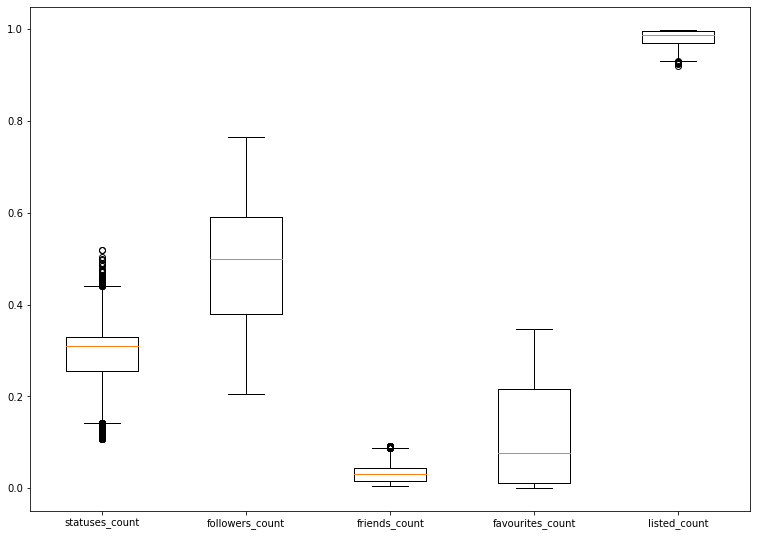

In [81]:
fig = plt.figure(figsize =(10, 7))
ax = fig.add_axes([0, 0, 1, 1])
# Creating plot
bp = ax.boxplot(X)
plt.xticks([1,2,3,4,5],['statuses_count','followers_count','friends_count','favourites_count','listed_count'])
# show plot
plt.show()

In [82]:
Q1 = X.quantile(0.25)
Q3 = X.quantile(0.75)
IQR = Q3 - Q1
((X < (Q1 - 1.5 * IQR)) | (X > (Q3 + 1.5 * IQR))).sum()

statuses_count      314
followers_count       0
friends_count        24
favourites_count      0
listed_count         10
dtype: int64

# Classifier Building

## Random Forest with AdaBoost

In [83]:
from sklearn.ensemble import RandomForestClassifier  
from sklearn.ensemble import AdaBoostClassifier 
from sklearn.metrics import recall_score as rs  
from sklearn.metrics import precision_score as ps  
from sklearn.metrics import f1_score as fs  
from sklearn.metrics import log_loss,confusion_matrix,accuracy_score
from sklearn import tree

In [84]:

rf = RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None, criterion='gini', max_depth=4, max_features='auto',  max_leaf_nodes=None, max_samples=None,  min_impurity_decrease=0.0,  min_samples_leaf=2, min_samples_split=2,  min_weight_fraction_leaf=0.0, n_estimators=5,  n_jobs=None, oob_score=False, random_state=None,  verbose=0, warm_start=False)  
classifier = AdaBoostClassifier(rf)  

classifier.fit(x_train,y_train)
pred = np.array(classifier.predict(x_test))  

recall = rs(y_test,pred)  
precision = ps(y_test,pred)  
r1 = fs(y_test,pred)  
ma = classifier.score(x_test,y_test)  
print('*** Evaluation metrics for test dataset ***\n')  
print('Recall Score: ',recall)  
print('Precision Score: ',precision)  
print('F1 Score: ',r1)  
print('Accuracy: ',accuracy_score(y_test,pred)) #1800, 1000epoch, 94%    #1800,2000epoch,95.8%   #2000,2000epoch,96%

*** Evaluation metrics for test dataset ***

Recall Score:  0.8914185639229422
Precision Score:  0.9368098159509203
F1 Score:  0.9135507029614119
Accuracy:  0.941068515497553


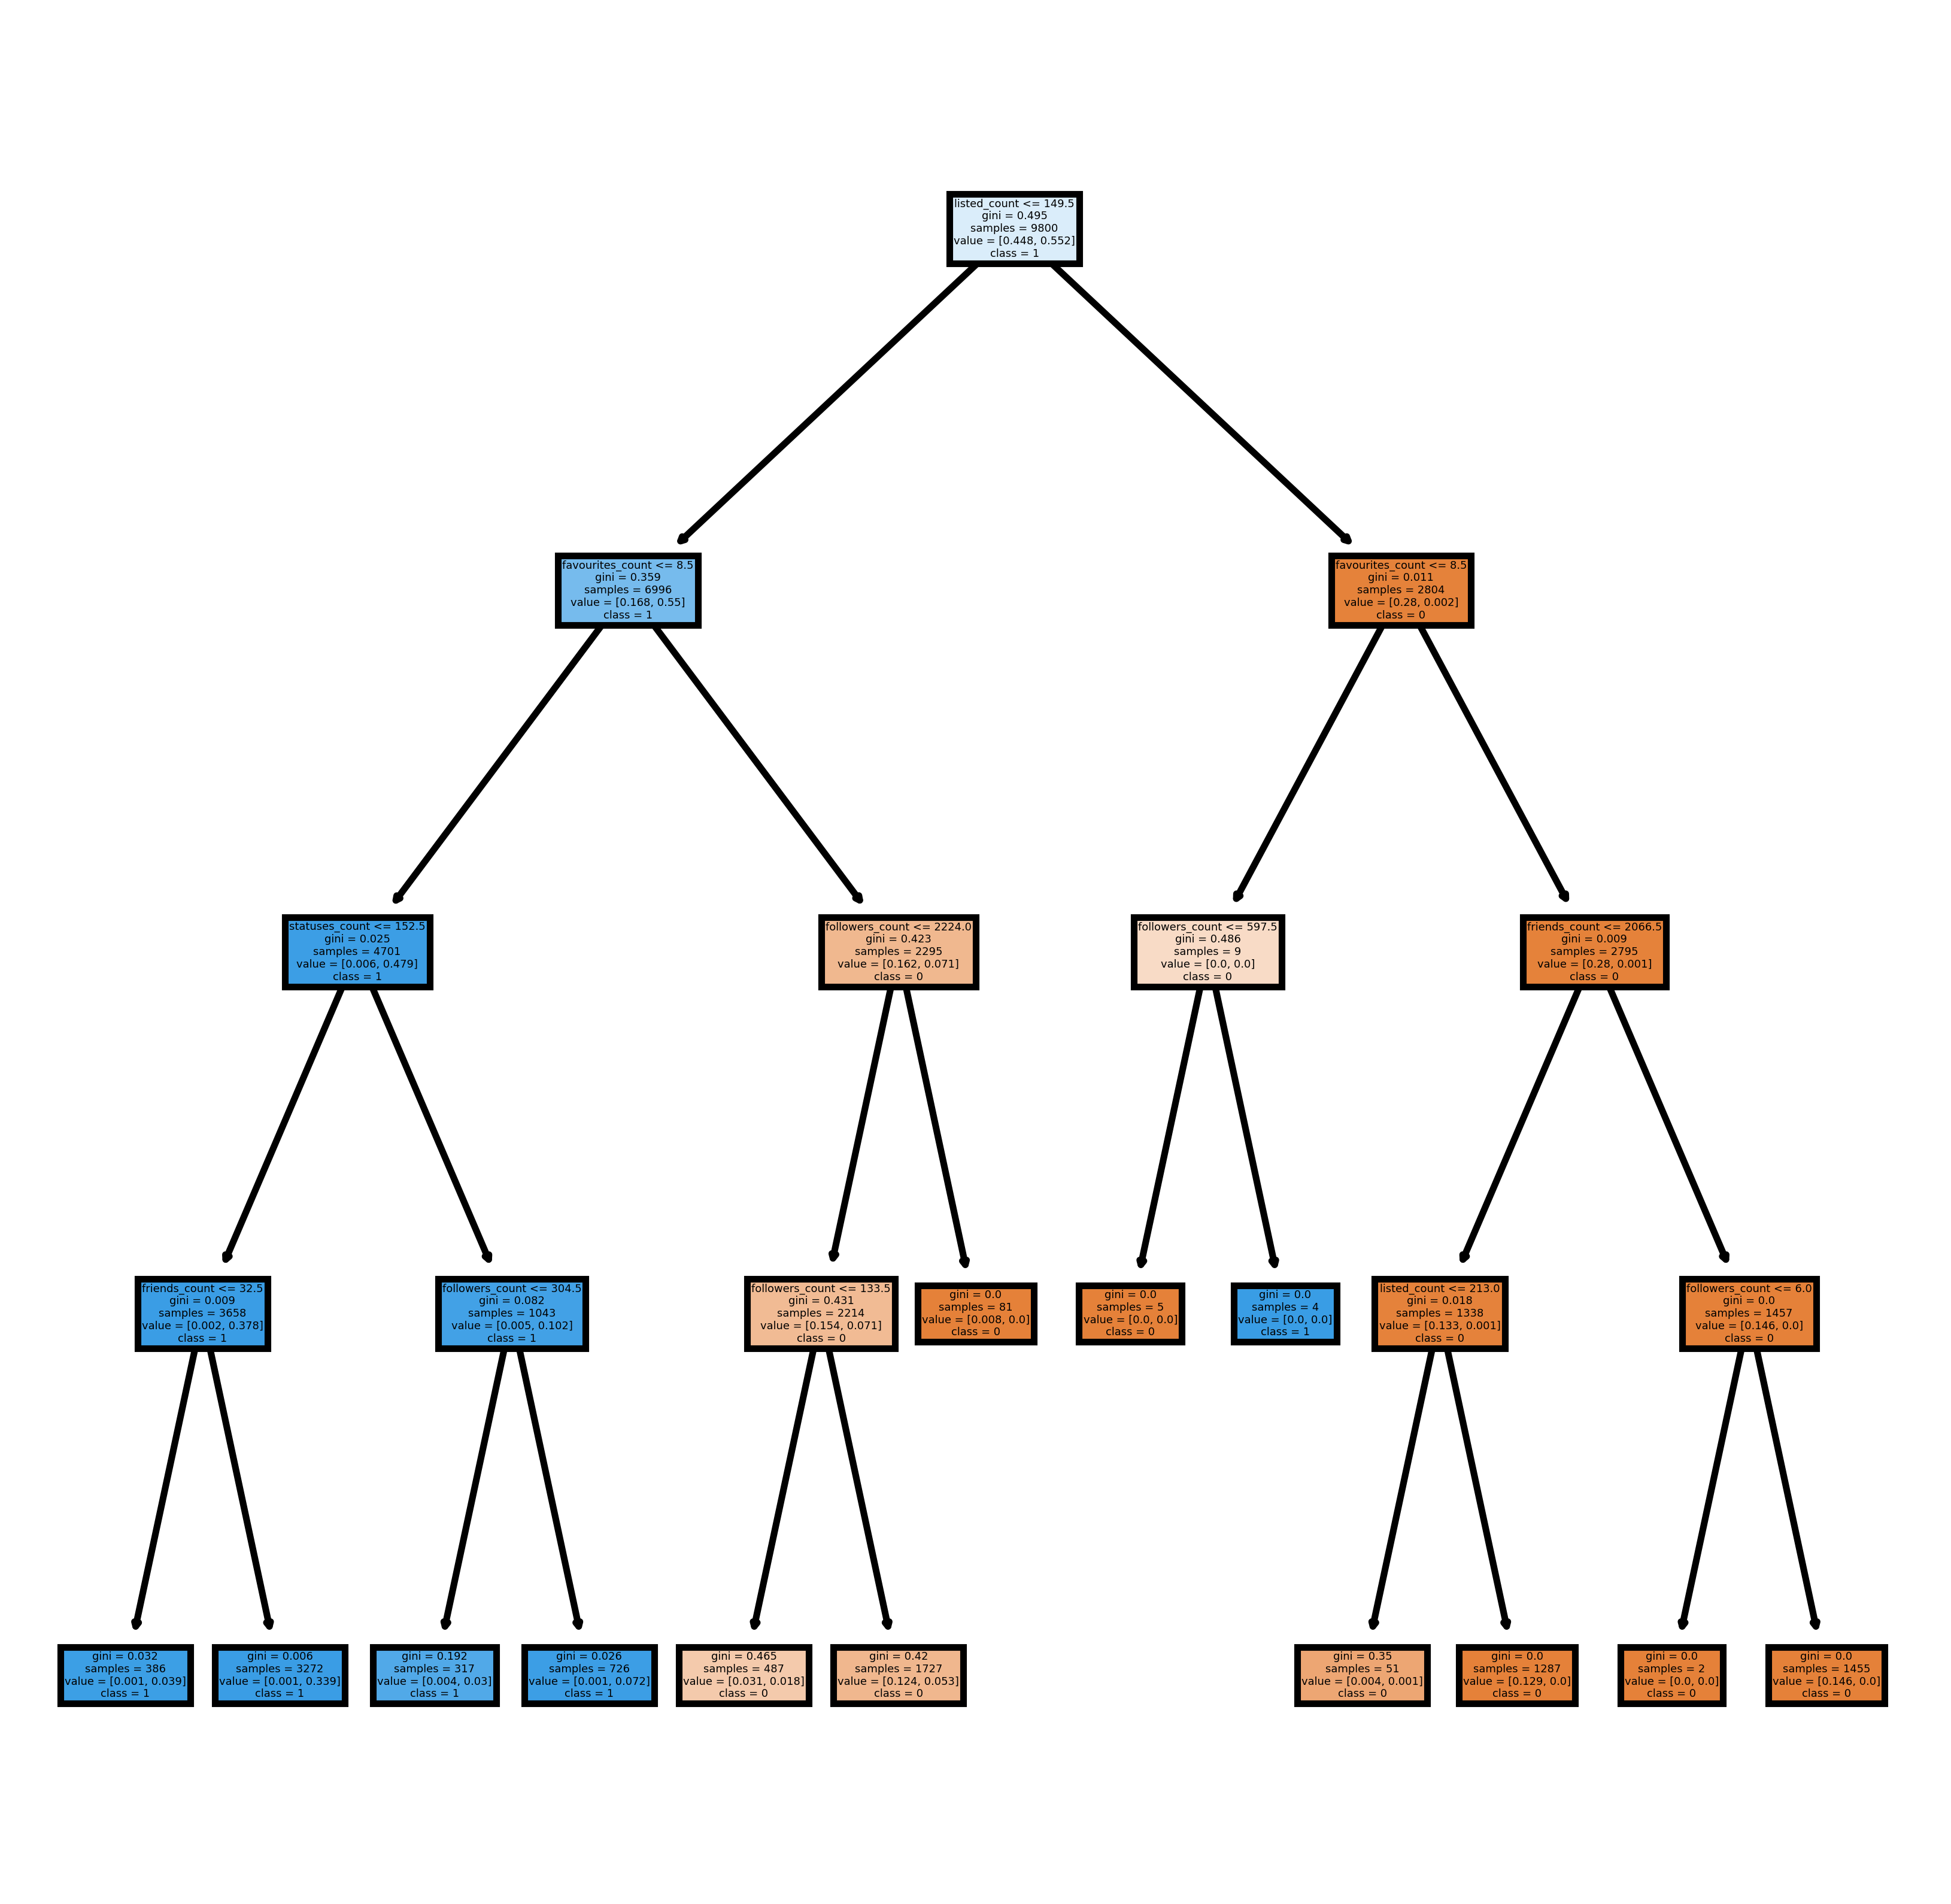

In [45]:
classifier.fit(data.iloc[:,:-1],data['Label'])
for i in range(1):
    for j in range(1):
        fig, axes = plt.subplots(nrows = 1,ncols = 1,figsize = (5,5), dpi=800)
        tree.plot_tree(classifier.estimators_[i][j],
                    feature_names = X.columns,class_names = ['0','1'], filled = True)

## Model Saving

In [125]:
import pickle
pickle.dump(classifier, open('GRU_RF.sav', 'wb'))

## Xgboost Classifier

In [85]:
import xgboost as xgb

xgb_cl = xgb.XGBClassifier()
xgb_cl.fit(x_train, y_train)

# Predict
pred = xgb_cl.predict(x_test)
recall = rs(y_test,pred)  
precision = ps(y_test,pred)  
r1 = fs(y_test,pred)  
ma = xgb_cl.score(x_test,y_test)  
print('*** Evaluation metrics for test dataset ***\n')  
print('Recall Score: ',recall)  
print('Precision Score: ',precision)  
print('F1 Score: ',r1)  
print('Accuracy: ',ma) 

C:\Users\GAYATHRI\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[01:48:50] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
*** Evaluation metrics for test dataset ***

Recall Score:  0.8925861062463515
Precision Score:  0.9391891891891891
F1 Score:  0.9152948219096079
Accuracy:  0.9422920065252854


## Model Saving

In [120]:
pickle.dump(xgb_cl, open('GRU_XG.sav', 'wb'))

No handles with labels found to put in legend.


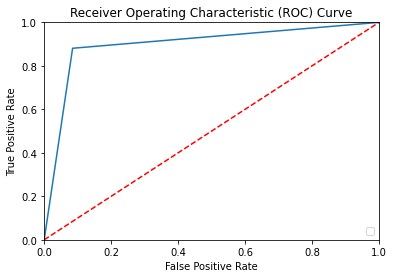

roc_auc_score:  0.8980398131092928


In [47]:
from sklearn.metrics import roc_curve,roc_auc_score

false_positive_rate, true_positive_rate, threshold = roc_curve(y_test, pred)
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.plot(false_positive_rate, true_positive_rate)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()
print('roc_auc_score: ', roc_auc_score(y_test, pred))

In [48]:
X = x_train.append(x_test,ignore_index=True)
Y = y_train.append(y_test,ignore_index=True)

## Xgboost Classifier with 5 fold Cross validation

In [49]:
from sklearn.model_selection import cross_val_score,KFold,StratifiedKFold,cross_val_predict,cross_validate
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score
from statistics import mean


scoring = {'accuracy' : make_scorer(accuracy_score), 
           'precision' : make_scorer(precision_score),
           'recall' : make_scorer(recall_score), 
           'f1_score' : make_scorer(f1_score)}

kf=KFold(n_splits=5,shuffle=True)
score=cross_validate(xgb_cl,X,Y,scoring=scoring,cv=kf) 
pred=cross_val_predict(xgb_cl,X,Y,cv=kf) 
print('Recall Score: ',score['test_recall'],"  Average",mean(score['test_recall']))  
print('Precision Score: ',score['test_precision'],"  Average",mean(score['test_precision']))  
print('F1 Score: ',score['test_f1_score'],"  Average",mean(score['test_f1_score']))  
print('Accuracy: ',score['test_accuracy'],"  Average",mean(score['test_accuracy'])) 

[00:58:11] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\GAYATHRI\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\GAYATHRI\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[00:58:14] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\GAYATHRI\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[00:58:16] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\GAYATHRI\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[00:58:19] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\GAYATHRI\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[00:58:21] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\GAYATHRI\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[00:58:24] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\GAYATHRI\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[00:58:26] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\GAYATHRI\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[00:58:27] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\GAYATHRI\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[00:58:30] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\GAYATHRI\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[00:58:31] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Recall Score:  [0.90743995 0.8962536  0.89228007 0.88419224 0.89254257]   Average 0.8945416880129876
Precision Score:  [0.93313253 0.94643944 0.91980259 0.93508879 0.9417596 ]   Average 0.9352445916526763
F1 Score:  [0.92010692 0.92066311 0.90583232 0.90892857 0.9164908 ]   Average 0.9144043463052318
Accuracy:  [0.91333763 0.91365979 0.90009668 0.90138576 0.91073155]   Average 0.9078422818290248
